In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.head(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
0,02-01-2009,108.379997,14261265,6.310420,141738,57.340000,1700495,16.889999,1359910,101.565002,...,97.900002,6258884,106.430000,2973855,133.184998,24161650,29.587500,9574565,134.700485,222908
1,05-01-2009,112.019997,9165605,6.504736,1120575,58.860001,2687100,17.129999,4379460,104.410004,...,99.637497,5956956,107.160004,3037185,136.080002,26931910,30.562500,8844514,136.025497,14449
2,06-01-2009,113.949997,12893855,6.660189,312830,57.750000,3162520,16.760000,1930260,110.040001,...,96.712502,9015300,106.089996,4110100,132.285004,35970960,29.831249,1078005,133.516418,102783
3,07-01-2009,104.419998,10571555,6.150109,166223,54.939999,5602350,16.459999,2251090,100.925003,...,90.762497,6482408,97.660004,6538860,124.004997,37268580,28.424999,5624090,131.853104,24863
4,09-01-2009,97.320000,25173105,6.048093,95905,54.689999,1806325,16.004999,4046570,101.750000,...,86.125000,5076276,97.129997,3834090,122.110001,24996510,28.818750,6157634,129.654144,301873


In [3]:
feature_columns = [ 'SBI', 'SBIVOL']
target_column = ['SBI']
features = df[feature_columns]
target = df[target_column].shift(-3)

new_data1 = 758.30
target.iloc[-3, 0] = new_data1

new_data2 = 766.40
target.iloc[-2, 0] = new_data2

new_data3 = 771.05
target.iloc[-1, 0] = new_data3


target.tail(5)

,SBI
3748,733.299988
3749,752.349976
3750,758.300000
3751,766.400000
3752,771.050000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
target=target.dropna()

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_sbi3_0.9610.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
R2: 0.9610
MAPE: 0.0252
RMSE: 17.2254
RMSE_normalizeddata: 0.0247
MAE_normalizeddata: 0.0191
MAE: 13.3099


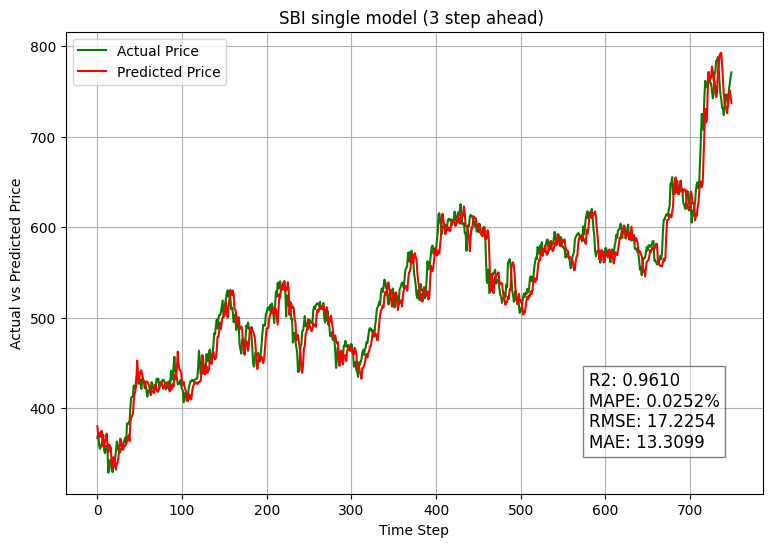

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('SBI single model (3 step ahead) ')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('sbi_3sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
R2: 0.9552
MAPE: 0.0366
RMSE: 11.4790
RMSE_normalizeddata: 0.0164
MAE_normalizeddata: 0.0122
MAE: 8.5107


In [28]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.1538e-04 - val_loss: 0.0028
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.0928e-04 - val_loss: 0.0021
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.6189e-04 - val_loss: 0.0034
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.5629e-04 - val_loss: 0.0020
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.3592e-04 - val_loss: 0.0025
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.7396e-04 - val_loss: 0.0028
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.4618e-04 - val_loss: 0.0021
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.7175e-04 - val_loss: 0.0017
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.5192e-04 - val_loss: 9.0498e-04
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.4910e-04 - val_loss: 0.0016
Epoch 12

In [29]:
model_lstm.save('model_lstm_bajajfin3h_1.keras')

In [30]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0136 - val_loss: 9.0880e-04
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.9272e-04 - val_loss: 9.4145e-04
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.9763e-04 - val_loss: 0.0015
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.6311e-04 - val_loss: 0.0018
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.8800e-04 - val_loss: 0.0029
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.8001e-04 - val_loss: 0.0019
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.6387e-04 - val_loss: 0.0024
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.7679e-04 - val_loss: 0.0018
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.8429e-04 - val_loss: 0.0016
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.4725e-04 - val_loss: 0.0013
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.3667e-04 - val_loss: 0.0015
Epoc

In [31]:
model_lstm.save('model_lstm_bajajfin3h_2.keras')

In [32]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0112 - val_loss: 9.0168e-04
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.9587e-04 - val_loss: 9.2354e-04
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.4750e-04 - val_loss: 0.0011
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.8851e-04 - val_loss: 0.0020
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.8406e-04 - val_loss: 9.2568e-04
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.8849e-04 - val_loss: 0.0023
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.7353e-04 - val_loss: 0.0015
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.5764e-04 - val_loss: 0.0012
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.6878e-04 - val_loss: 0.0019
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 3.4207e-04 - val_loss: 0.0021
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.5534e-04 - val_loss: 0.0015


In [33]:
model_lstm.save('model_lstm_bajajfin3h_3.keras')

In [34]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0122 - val_loss: 0.0010
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.9744e-04 - val_loss: 0.0021
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.3675e-04 - val_loss: 0.0022
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.6835e-04 - val_loss: 0.0027
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.5932e-04 - val_loss: 0.0027
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.9600e-04 - val_loss: 0.0027
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.9644e-04 - val_loss: 0.0025
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.7810e-04 - val_loss: 0.0015
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.6706e-04 - val_loss: 0.0014
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.7473e-04 - val_loss: 0.0030
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.9691e-04 - val_loss: 0.0023
Epoch 12/20

In [35]:
model_lstm.save('model_lstm_bajajfin3h_4.keras')

In [36]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 0.0119 - val_loss: 0.0010
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8404e-04 - val_loss: 0.0011
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.6983e-04 - val_loss: 0.0021
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.7150e-04 - val_loss: 0.0042
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.2659e-04 - val_loss: 0.0026
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.7838e-04 - val_loss: 0.0024
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.5137e-04 - val_loss: 0.0025
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.6557e-04 - val_loss: 0.0011
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.6053e-04 - val_loss: 0.0023
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.6452e-04 - val_loss: 0.0011
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.5309e-04 - val_loss: 0.0018
Epoch 12/20

In [37]:
model_lstm.save('model_lstm_bajajfin3h_5.keras')

In [38]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0110 - val_loss: 9.5367e-04
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.7364e-04 - val_loss: 0.0016
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.6469e-04 - val_loss: 0.0014
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.6285e-04 - val_loss: 0.0019
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.8703e-04 - val_loss: 0.0020
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 3.7359e-04 - val_loss: 0.0023
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.6273e-04 - val_loss: 0.0022
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.5247e-04 - val_loss: 0.0014
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.6652e-04 - val_loss: 0.0024
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.4000e-04 - val_loss: 9.6784e-04
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.4400e-04 - val_loss: 0.0018
Epo

In [39]:
model_lstm.save('model_lstm_bajajfin3h_6.keras')

In [40]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0122 - val_loss: 8.7718e-04
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 4.0159e-04 - val_loss: 0.0010
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 3.7184e-04 - val_loss: 0.0015
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.8605e-04 - val_loss: 0.0022
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.9374e-04 - val_loss: 0.0019
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.6257e-04 - val_loss: 0.0012
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 3.9221e-04 - val_loss: 0.0016
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.6854e-04 - val_loss: 0.0021
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.6091e-04 - val_loss: 0.0025
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 3.3762e-04 - val_loss: 0.0013
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.4136e-04 - val_loss: 0.0014
Epoch 1

In [41]:
model_lstm.save('model_lstm_bajajfin3h_7.keras')

In [42]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0110 - val_loss: 0.0013
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.7653e-04 - val_loss: 8.6424e-04
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.0206e-04 - val_loss: 9.0496e-04
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.6439e-04 - val_loss: 0.0012
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.6802e-04 - val_loss: 0.0013
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 3.9954e-04 - val_loss: 0.0023
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.5410e-04 - val_loss: 0.0014
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 3.5667e-04 - val_loss: 0.0020
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.8957e-04 - val_loss: 0.0013
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.8036e-04 - val_loss: 0.0020
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.5726e-04 - val_loss: 0.0014
Epo

In [43]:
model_lstm.save('model_lstm_bajajfin3h_8.keras')

In [44]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0106 - val_loss: 0.0013
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.0726e-04 - val_loss: 8.9705e-04
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.6697e-04 - val_loss: 0.0017
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.8333e-04 - val_loss: 0.0013
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.7750e-04 - val_loss: 9.9679e-04
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.5755e-04 - val_loss: 0.0010
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.5740e-04 - val_loss: 0.0025
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.4106e-04 - val_loss: 0.0017
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 3.4985e-04 - val_loss: 0.0014
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.9208e-04 - val_loss: 0.0012
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.5317e-04 - val_loss: 0.0019
Epoc

In [45]:
model_lstm.save('model_lstm_bajajfin3h_9.keras')

In [46]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0121 - val_loss: 0.0011
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.6627e-04 - val_loss: 0.0014
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.8689e-04 - val_loss: 0.0016
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.6946e-04 - val_loss: 0.0018
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.1997e-04 - val_loss: 0.0011
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.8686e-04 - val_loss: 0.0025
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.0228e-04 - val_loss: 0.0012
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.8061e-04 - val_loss: 0.0020
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.4958e-04 - val_loss: 0.0027
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.0190e-04 - val_loss: 0.0015
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.7968e-04 - val_loss: 8.9788e-04
Epoch 1

In [47]:
predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
R2: 0.9533
MAPE: 0.0381
RMSE: 11.7184
RMSE_normalizeddata: 0.0168
MAE_normalizeddata: 0.0126
MAE: 8.7975


In [48]:
model_lstm.save('model_lstm_bajajfin3h_10.keras')